# Testing Predictions of the variants of MILD

In [1]:
%matplotlib widget
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import torch
import os

from mild_hri.utils import *
from mild_hri.dataloaders import *


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

pred_mse = []
pred_mse_nowave = []
pred_mse_wave = []
pred_mse_shake = []
pred_mse_rocket = []
pred_mse_parachute = []
labels = []
vae_mse = []

# epochs = [400]
# epochs = np.arange(50,401,10)
model_epochs = {
					# Human-Human
					# 'v1_1/diaghmm_z3h5':400,	# 'v1_1/diaghmm_z5h5':240,	# 'v1_1/diaghmm_z8h5':350,
					# 'v2_1/diaghmm_z3h5':50,	# 'v2_1/diaghmm_z5h5':240,	# 'v2_1/diaghmm_z8h5':200,
					# 'v2_2/diaghmm_z3h5':50,	# 'v2_2/diaghmm_z5h5':60,	# 'v2_2/diaghmm_z8h5':400,
					# 'v3_1/diaghmm_z3h5':350,	# 'v3_1/diaghmm_z5h5':380,	# 'v3_1/diaghmm_z8h5':180,
					# 'v3_2/diaghmm_z3h5':220,	# 'v3_2/diaghmm_z5h5':210,	# 'v3_2/diaghmm_z8h5':390,

					# Pepper (trial means)
					'v1_1/diaghmm_z3h5':400,	'v1_1/diaghmm_z5h5':310,	'v1_1/diaghmm_z8h5':400,
					# 'v1_1/diaghmm_z3h6':210,	'v1_1/diaghmm_z5h6':390,	'v1_1/diaghmm_z8h6':380,
					# 'v1_1/diaghmm_z3h7':120,	'v1_1/diaghmm_z5h7':400,	'v1_1/diaghmm_z8h7':120,
					# 'v1_1/diaghmm_z3h8':360,	'v1_1/diaghmm_z5h8':380,	'v1_1/diaghmm_z8h8':250,

					'v2_1/diaghmm_z3h5':330,	'v2_1/diaghmm_z5h5':320,	'v2_1/diaghmm_z8h5':200,
					# 'v2_1/diaghmm_z3h6':330,	'v2_1/diaghmm_z5h6':340,	'v2_1/diaghmm_z8h6':360,
					# 'v2_1/diaghmm_z3h7':370,	'v2_1/diaghmm_z5h7':290,	'v2_1/diaghmm_z8h7':50,
					# 'v2_1/diaghmm_z3h8':70 ,	'v2_1/diaghmm_z5h8':100,	'v2_1/diaghmm_z8h8':360,
					
					'v2_2/diaghmm_z3h5':290,	'v2_2/diaghmm_z5h5':360,	'v2_2/diaghmm_z8h5':400,
					# 'v2_2/diaghmm_z3h6':350,	'v2_2/diaghmm_z5h6':240,	'v2_2/diaghmm_z8h6':290,
					# 'v2_2/diaghmm_z3h7':370,	'v2_2/diaghmm_z5h7':240,	'v2_2/diaghmm_z8h7':110,
					# 'v2_2/diaghmm_z3h8':130,	'v2_2/diaghmm_z5h8':100,	'v2_2/diaghmm_z8h8':330,

					'v3_1/diaghmm_z3h5':300,	'v3_1/diaghmm_z5h5':380,	'v3_1/diaghmm_z8h5':280,
					# 'v3_1/diaghmm_z3h6':380,	'v3_1/diaghmm_z5h6':150,	'v3_1/diaghmm_z8h6':310,
					# 'v3_1/diaghmm_z3h7':330,	'v3_1/diaghmm_z5h7':290,	'v3_1/diaghmm_z8h7':310,
					# 'v3_1/diaghmm_z3h8':270,	'v3_1/diaghmm_z5h8':390,	'v3_1/diaghmm_z8h8':390,

					'v3_2/diaghmm_z3h5':220,	'v3_2/diaghmm_z5h5':210,	'v3_2/diaghmm_z8h5':390,
					# 'v3_2/diaghmm_z3h6':170,	'v3_2/diaghmm_z5h6':120,	'v3_2/diaghmm_z8h6':380,
					# 'v3_2/diaghmm_z3h7':180,	'v3_2/diaghmm_z5h7':380,	'v3_2/diaghmm_z8h7':350,
					# 'v3_2/diaghmm_z3h8':310,	'v3_2/diaghmm_z5h8':370,	'v3_2/diaghmm_z8h8':210,
			}

print('Model Type\tEpochs\tTrial\tPred. MSE (all)\tPred. MSE w/o waving\tPred. MSE waving\tPred. MSE handshake\tPred. MSE rocket\tPred. MSE parachute\n')
for model_type in model_epochs:
	# for epoch in epochs:
		epoch = model_epochs[model_type]
		pred_mse_k = []
		pred_mse_nowave_k = []
		pred_mse_wave_k = []
		pred_mse_shake_k = []
		pred_mse_rocket_k = []
		pred_mse_parachute_k = []
		for trial in range(4):
			if epoch == 400:
				ckpt_path = f'../logs/2023/bp_pepper_20hz/{model_type}/trial{trial}/models/final_399.pth'
			else:
				ckpt_path = f'../logs/2023/bp_pepper_20hz/{model_type}/trial{trial}/models/' + '%0.3d'%epoch + '.pth'
	
			ckpt = torch.load(ckpt_path)
			pred_mse_ckpt, pred_mse_nowave_ckpt, pred_mse_wave_ckpt, pred_mse_shake_ckpt, pred_mse_rocket_ckpt, pred_mse_parachute_ckpt = evaluate_ckpt_hr(ckpt_path)
			if np.any(np.isnan(pred_mse_ckpt)):
				print(model_type, trial)
				continue
			pred_mse_k += pred_mse_ckpt
			pred_mse_nowave_k += pred_mse_nowave_ckpt
			pred_mse_wave_k += pred_mse_wave_ckpt
			pred_mse_shake_k += pred_mse_shake_ckpt
			pred_mse_rocket_k += pred_mse_rocket_ckpt
			pred_mse_parachute_k += pred_mse_parachute_ckpt
			# print(f'{model_type}\t{epoch}\t{trial}\t{np.mean(pred_mse_ckpt):.4e} ± {np.std(pred_mse_ckpt):.4e}\t{np.mean(pred_mse_nowave_ckpt):.4e} ± {np.std(pred_mse_nowave_ckpt):.4e}\t{np.mean(pred_mse_wave_ckpt):.4e} ± {np.std(pred_mse_wave_ckpt):.4e}\t{np.mean(pred_mse_shake_ckpt):.4e} ± {np.std(pred_mse_shake_ckpt):.4e}\t{np.mean(pred_mse_rocket_ckpt):.4e} ± {np.std(pred_mse_rocket_ckpt):.4e}\t{np.mean(pred_mse_parachute_ckpt):.4e} ± {np.std(pred_mse_parachute_ckpt):.4e}')
		pred_mse.append(pred_mse_k)
		pred_mse_nowave.append(pred_mse_nowave_k)
		pred_mse_wave.append(pred_mse_wave_k)
		pred_mse_shake.append(pred_mse_shake_k)
		pred_mse_rocket.append(pred_mse_rocket_k)
		pred_mse_parachute.append(pred_mse_parachute_k)
		print(f'{model_type}\t{epoch}\tall\t{np.mean(pred_mse_k):.4e} ± {np.std(pred_mse_k):.4e}\t{np.mean(pred_mse_nowave_k):.4e} ± {np.std(pred_mse_nowave_k):.4e}\t{np.mean(pred_mse_wave_k):.4e} ± {np.std(pred_mse_wave_k):.4e}\t{np.mean(pred_mse_shake_k):.4e} ± {np.std(pred_mse_shake_k):.4e}\t{np.mean(pred_mse_rocket_k):.4e} ± {np.std(pred_mse_rocket_k):.4e}\t{np.mean(pred_mse_parachute_k):.4e} ± {np.std(pred_mse_parachute_k):.4e}')

	# print('\n')
	


Model Type	Epochs	Trial	Pred. MSE (all)	Pred. MSE w/o waving	Pred. MSE waving	Pred. MSE handshake	Pred. MSE rocket	Pred. MSE parachute

v1_1/diaghmm_z3h5	400	all	2.6365e-01 ± 3.3649e-01	1.3569e-01 ± 2.5281e-01	5.9464e-01 ± 2.9812e-01	1.3003e-01 ± 2.6238e-01	6.9991e-02 ± 1.5209e-01	1.8125e-01 ± 2.8223e-01
v1_1/diaghmm_z5h5	310	all	1.6298e-01 ± 1.8206e-01	1.0816e-01 ± 1.1353e-01	3.0478e-01 ± 2.4014e-01	9.9784e-02 ± 7.4033e-02	5.9817e-02 ± 7.7740e-02	1.4558e-01 ± 1.4501e-01
v1_1/diaghmm_z8h5	400	all	1.1363e-01 ± 1.4765e-01	1.0259e-01 ± 1.4744e-01	1.4219e-01 ± 1.4433e-01	1.0248e-01 ± 7.8132e-02	5.0642e-02 ± 7.9113e-02	1.3460e-01 ± 2.0732e-01
v2_1/diaghmm_z3h5	330	all	1.1807e-01 ± 1.7590e-01	5.2161e-02 ± 9.3470e-02	2.8856e-01 ± 2.1924e-01	4.8188e-02 ± 3.6375e-02	3.7095e-02 ± 5.6818e-02	6.5079e-02 ± 1.3652e-01
v2_1/diaghmm_z5h5	320	all	6.9524e-02 ± 1.2392e-01	4.5902e-02 ± 1.0171e-01	1.3063e-01 ± 1.5211e-01	3.5041e-02 ± 2.8417e-02	1.5117e-02 ± 3.4924e-02	7.4826e-02 ± 1.5238e-01
v2_1/diaghmm_z

	v1_1/z3h5	v1_1/z5h5	v1_1/z8h5	v2_1/z3h5	v2_1/z5h5	v2_1/z8h5	v2_2/z3h5	v2_2/z5h5	v2_2/z8h5	v3_1/z3h5	v3_1/z5h5	v3_1/z8h5	v3_2/z3h5	v3_2/z5h5	v3_2/z8h5	
v1_1/z3h5	.	**	**	**	**	**	**	**	**	**	**	**	**	**	**	
v1_1/z5h5	.	.	**	**	**	**	**	**	**	**	**	**	**	**	**	
v1_1/z8h5	.	.	.	**	**	**	**	**	**	**	**	**	**	**	**	
v2_1/z3h5	.	.	.	.	**	**	*	**	**	**	**	**	**	**	**	
v2_1/z5h5	.	.	.	.	.	**	**	**	o	**	**	o	**	**	**	
v2_1/z8h5	.	.	.	.	.	.	**	**	**	**	**	**	**	**	**	
v2_2/z3h5	.	.	.	.	.	.	.	**	**	**	**	**	**	**	**	
v2_2/z5h5	.	.	.	.	.	.	.	.	**	**	o	**	**	o	**	
v2_2/z8h5	.	.	.	.	.	.	.	.	.	**	**	o	**	**	**	
v3_1/z3h5	.	.	.	.	.	.	.	.	.	.	**	**	o	**	**	
v3_1/z5h5	.	.	.	.	.	.	.	.	.	.	.	**	**	o	**	
v3_1/z8h5	.	.	.	.	.	.	.	.	.	.	.	.	**	**	**	
v3_2/z3h5	.	.	.	.	.	.	.	.	.	.	.	.	.	**	**	
v3_2/z5h5	.	.	.	.	.	.	.	.	.	.	.	.	.	.	**	
v3_2/z8h5	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	



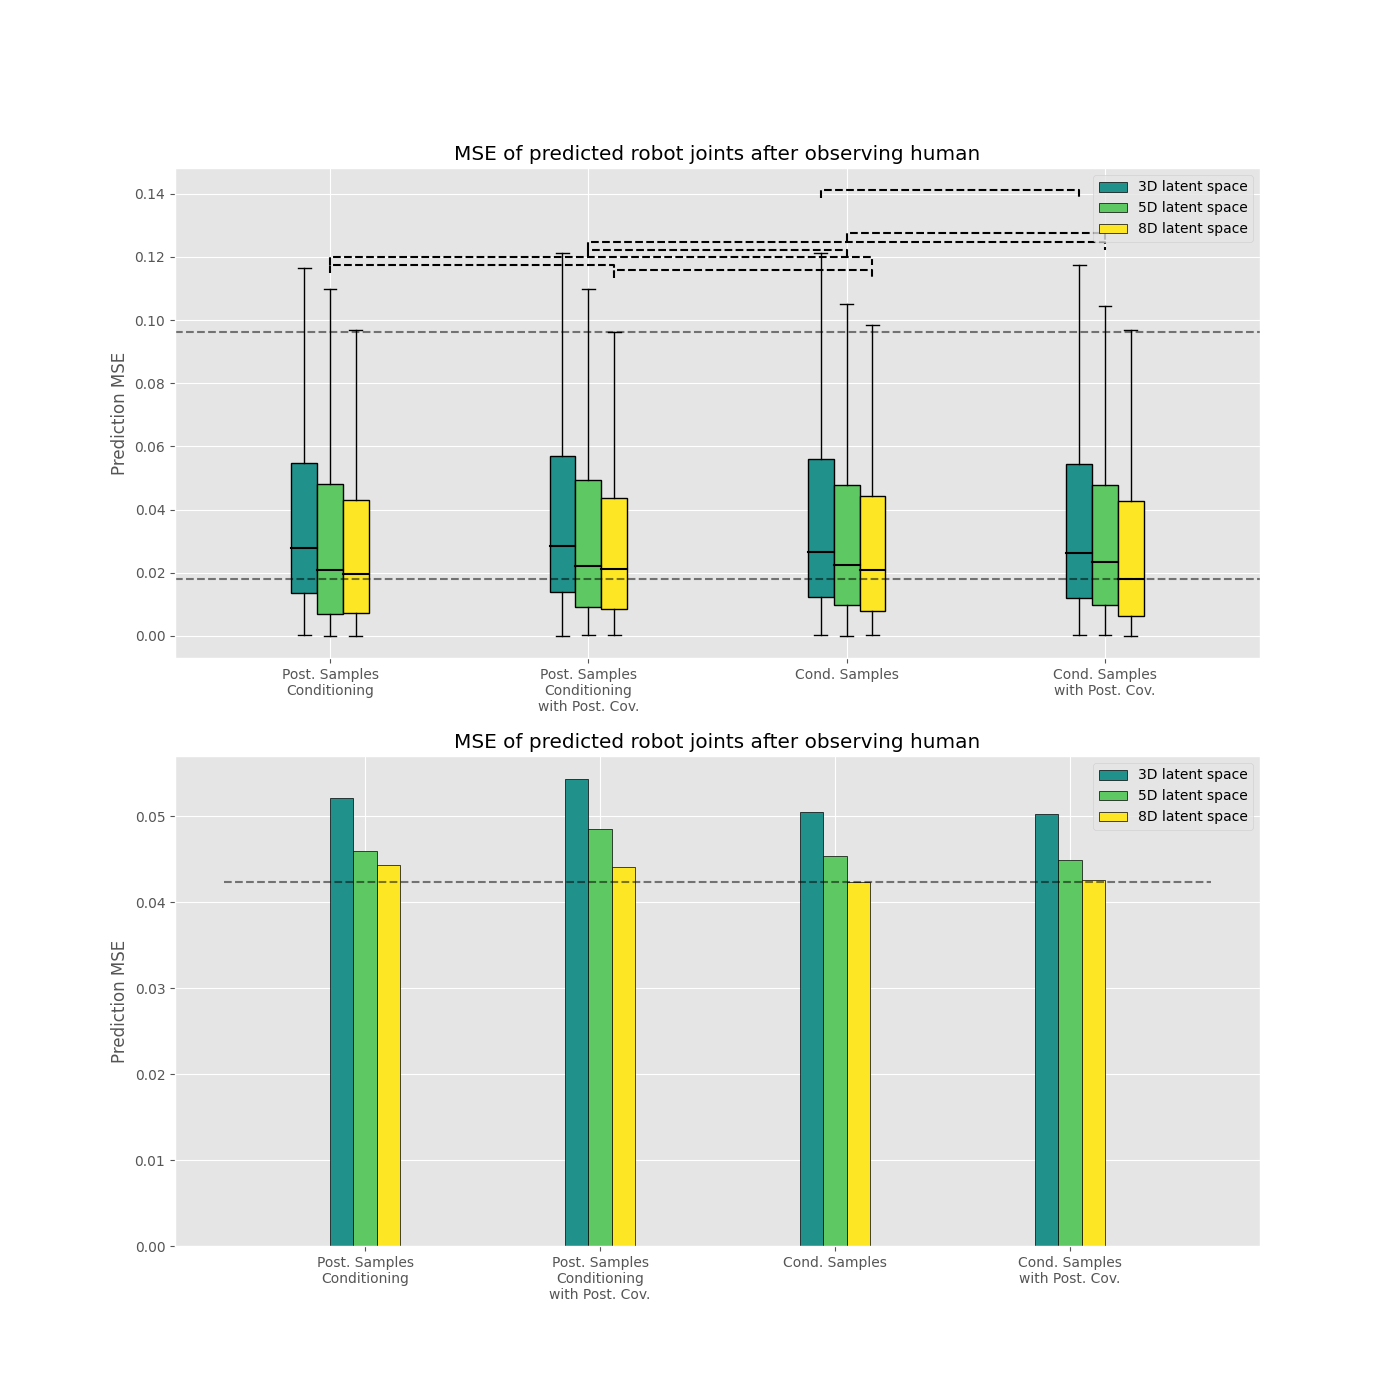

In [18]:
models = [i[:5]+i[-4:] for i in list(model_epochs.keys())]
p_values = np.ones((len(pred_mse_nowave), len(pred_mse_nowave)))

# for i in range(len(pred_mse)-1):
# 	for j in range(i+1,len(pred_mse)):
# 		p_values[i,j] = scipy.stats.ttest_ind(pred_mse[i], pred_mse[j]).pvalue
		
# s = '\t'
# for i in range(3,len(models)):
# 	s+= models[i]+'\t'
# s+='\n'
# for i in range(3,len(pred_mse)):
# 	s+= models[i]+'\t'
# 	for j in range(3,len(pred_mse)):
# 		if j<=i:
# 			s += '.\t'
# 		else:
# 			if p_values[i,j] < 0.01:
# 				s += '**\t'
# 			elif p_values[i,j] < 0.05:
# 				s += '*\t'
# 			else:
# 				s += 'o\t'
# 	s+='\n'
# print(s)


# print('\n')
# p_values = np.ones((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
# 	for j in range(i+1,len(pred_mse)):
# 		p_values[i,j] = scipy.stats.ttest_rel(pred_mse[i], pred_mse[j]).pvalue
# 		if p_values[i,j]>0.05:
# 			print(models[i],models[j],p_values[i,j])
# print('\n')

p_values = np.zeros((len(pred_mse_nowave), len(pred_mse_nowave)))
for i in range(len(pred_mse_nowave)-1):
	for j in range(i+1,len(pred_mse_nowave)):
		p_values[i,j] = scipy.stats.mannwhitneyu(pred_mse_nowave[i], pred_mse_nowave[j]).pvalue
		# if p_values[i,j]>0.05:
		# 	print(models[i],models[j],p_values[i,j])
		# 	p_values[i,j] = 0.051

s = '\t'
for i in range(len(models)):
	s+= models[i]+'\t'
s+='\n'
for i in range(len(pred_mse_nowave)):
	s+= models[i]+'\t'
	for j in range(len(pred_mse_nowave)):
		if j<=i:
			s += '.\t'
		else:
			if p_values[i,j] < 0.01:
				s += '**\t'
			elif p_values[i,j] < 0.05:
				s += '*\t'
			else:
				s += 'o\t'
	s+='\n'
print(s)

fig = plt.figure(figsize=(14,14))
ax_box_pred = plt.subplot(2,1,1)
# ax_box_vae = plt.subplot(2,2,2)
ax_bar_pred = plt.subplot(2,1,2)
# p_plot = plt.subplot(3,1,3)
# heatmap = p_plot.pcolor(p_values)
# p_plot.colorbar(heatmap)
# ax_bar_vae = plt.subplot(2,2,4)
k = 0
ax_box_pred.set_title('MSE of predicted robot joints after observing human')
ax_bar_pred.set_title('MSE of predicted robot joints after observing human')

# X = np.arange(len(pred_mse))
mean_pred_mse = np.array([np.mean(pred_mse_nowave[i]) for i in range(len(pred_mse_nowave))])
med_pred_mse = np.array([np.median(pred_mse_nowave[i]) for i in range(len(pred_mse_nowave))])

colors = get_cmap()(np.linspace(0.5,1,3))
labels = ['3D latent space', '5D latent space', '8D latent space']

X = np.array([[i + j*0.1 + 0.05 for j in range(3)] for i in range(5)]).flatten()
ax_bar_pred.bar(X[3:], mean_pred_mse[3:], color = colors, width = 0.1, label=labels, edgecolor='k')#, label='100 epochs')
# ax_bar_pred.bar(X[1::3], mean_pred_mse[1::3], color = colors[1], width = 0.1, label=labels[1], edgecolor='k')#, label='100 epochs')
# ax_bar_pred.bar(X[2::3], mean_pred_mse[2::3], color = colors[2], width = 0.1, label=labels[2], edgecolor='k')#, label='100 epochs')
# ax_bar_pred.bar(X, med_pred_mse, color = 'm', width = 0.5, label='median')#, label='100 epochs')

ax_bar_pred.plot([X[3]-0.5, X[-1]+0.5], [mean_pred_mse.min(), mean_pred_mse.min()], 'k--', alpha = 0.5)#, label='100 epochs')

bars = []
min_whiskers_y = 10
max_whiskers_y = -10
for i in range(3,len(pred_mse_nowave)):
	# if i%3 == 0:
	# 	continue
	bars.append(ax_box_pred.boxplot(pred_mse_nowave[i], positions=[X[i]], showfliers=False, widths=[0.1], patch_artist = True,
		   boxprops = dict(facecolor=colors[i%3]), 
		   medianprops = dict(color = "black", linewidth = 1.5),
		   labels=[labels[i%3]]))
	if bars[-1]['caps'][1].get_ydata()[0] < min_whiskers_y:
		min_whiskers_y = bars[-1]['caps'][1].get_ydata()[0]
	if bars[-1]['caps'][1].get_ydata()[0] > max_whiskers_y:
		max_whiskers_y = bars[-1]['caps'][1].get_ydata()[0]
	
ax_box_pred.plot([X[3]-0.5, X[-1]+0.5], [med_pred_mse.min(), med_pred_mse.min()], 'k--', alpha = 0.5)#, label='100 epochs')
ax_box_pred.plot([X[3]-0.5, X[-1]+0.5], [min_whiskers_y, min_whiskers_y], 'k--', alpha = 0.5)#, label='100 epochs')

ax_bar_pred.set_ylabel('Prediction MSE')
ax_box_pred.set_ylabel('Prediction MSE')
ax_bar_pred.set_xticks(X[4::3], ('Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.',))# 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', ))
ax_box_pred.set_xticks(X[4::3], ('Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.',))# 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', ))


count_j = 0
for j in range(3,len(pred_mse_nowave)):
	count_k = 0
	for k in range(j+1,len(pred_mse_nowave)):
		if p_values[j,k]>=0.05:
			y, h, col = np.max([bars[j-3]['caps'][1].get_ydata()[0],bars[k-3]['caps'][1].get_ydata()[0]])+np.max([count_j,count_k])*0.0025+0.005, 0.0025, 'k'
			if p_values[j,k]<0.05:
				ax_box_pred.plot([X[j], X[j], X[k], X[k]], [y, y+h, y+h, y], lw=1.5, c=col, linestyle='-')
				# ax_box_pred.text((X[k]+X[j])*.5, y+h, "*", ha='center', va='bottom', color=col,fontweight='bold',fontsize=20)
			else:
				ax_box_pred.plot([X[j], X[j], X[k], X[k]], [y, y+h, y+h, y], lw=1.5, c=col, linestyle='--')
				# ax_box_pred.text((X[k]+X[j])*.5, y+h, "o", ha='center', va='bottom', color=col,fontweight='bold',fontsize=20)
			count_k += 1
			count_j += 1

ax_bar_pred.legend([plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='k') for i in range(len(labels))], labels, loc='upper right')
ax_box_pred.legend([plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='k') for i in range(len(labels))], labels, loc='upper right')
# # ax_bar_pred.set_ylim(top=0.21)
plt.show()

# # 100 epochs hh with waving
# # v1_1/diaghmm_z3h5 100	4.2367e-03 ± 6.2869e-03 	1.2224e-03 ± 8.6947e-04
# # v2_1/diaghmm_z3h5 100	4.2156e-03 ± 6.3374e-03 	1.2241e-03 ± 9.0192e-04
# # v2_2/diaghmm_z3h5 100	4.1929e-03 ± 6.3737e-03 	1.2283e-03 ± 8.8580e-04
# # v3_1/diaghmm_z3h5 100	4.3807e-03 ± 6.4302e-03 	1.2859e-03 ± 8.8117e-04
# # v3_2/diaghmm_z3h5 100	4.2122e-03 ± 6.3869e-03 	1.2634e-03 ± 8.9371e-04
# # v4_1/diaghmm_z3h5 100	4.2876e-03 ± 6.3639e-03 	1.2594e-03 ± 8.8222e-04
# # v4_2/diaghmm_z3h5 100	4.2461e-03 ± 6.2697e-03 	1.2510e-03 ± 9.0307e-04

# # 100 epochs hh without waving
# # v1_1/diaghmm_z3h5 100	3.3062e-03 ± 4.0426e-03 	1.1037e-03 ± 8.1811e-04
# # v2_1/diaghmm_z3h5 100	3.2887e-03 ± 4.0806e-03 	1.0944e-03 ± 8.5014e-04
# # v2_2/diaghmm_z3h5 100	3.2853e-03 ± 4.1741e-03 	1.0939e-03 ± 8.2047e-04
# # v3_1/diaghmm_z3h5 100	3.4537e-03 ± 4.1227e-03 	1.1919e-03 ± 8.5463e-04
# # v3_2/diaghmm_z3h5 100	3.2837e-03 ± 4.0811e-03 	1.1580e-03 ± 8.5286e-04
# # v4_1/diaghmm_z3h5 100	3.3201e-03 ± 4.0605e-03 	1.1305e-03 ± 8.2167e-04
# # v4_2/diaghmm_z3h5 100	3.2803e-03 ± 4.1187e-03 	1.1365e-03 ± 8.7073e-04


# # 400 epochs bp_pepper_20hz without waving
# # v1_1/diaghmm_z3h5 400	1.3569e-01 ± 2.5281e-01 	8.7684e-03 ± 8.8397e-03
# # v2_1/diaghmm_z3h5 400	5.2659e-02 ± 9.6123e-02 	1.1217e-02 ± 1.0335e-02
# # v2_2/diaghmm_z3h5 400	5.8945e-02 ± 1.1318e-01 	1.1852e-02 ± 1.1038e-02
# # v3_1/diaghmm_z3h5 400	5.1885e-02 ± 9.5199e-02 	1.3948e-02 ± 1.4626e-02
# # v3_2/diaghmm_z3h5 400	5.0402e-02 ± 9.2115e-02 	1.4135e-02 ± 1.4213e-02
# # v4_1/diaghmm_z3h5 400	5.0746e-02 ± 9.1155e-02 	1.4699e-02 ± 1.4931e-02
# # v4_2/diaghmm_z3h5 400	5.1632e-02 ± 8.8643e-02 	1.3974e-02 ± 1.2725e-02

# # 400 epochs bp_pepper_20hz with waving
# # v1_1/diaghmm_z3h5 400	2.6365e-01 ± 3.3649e-01 	1.0818e-02 ± 1.0526e-02
# # v2_1/diaghmm_z3h5 400	1.2379e-01 ± 1.9195e-01 	1.3779e-02 ± 1.1862e-02
# # v2_2/diaghmm_z3h5 400	1.1074e-01 ± 1.6144e-01 	1.4567e-02 ± 1.2600e-02
# # v3_1/diaghmm_z3h5 400	7.1058e-02 ± 1.1302e-01 	1.6456e-02 ± 1.4895e-02
# # v3_2/diaghmm_z3h5 400	7.0113e-02 ± 1.1113e-01 	1.8800e-02 ± 1.9126e-02
# # v4_1/diaghmm_z3h5 400	7.0829e-02 ± 1.0957e-01 	1.8129e-02 ± 1.6469e-02
# # v4_2/diaghmm_z3h5 400	7.1232e-02 ± 1.0835e-01 	1.6803e-02 ± 1.3736e-02


# # 400 epochs bp_pepper_20hz_norm without waving
# # v1_1/diaghmm_z3h5 400	1.3201e-01 ± 2.1314e-01 	3.5618e-01 ± 6.5011e-02
# # v2_1/diaghmm_z3h5 400	5.4312e-02 ± 9.9336e-02 	3.3811e-01 ± 6.3651e-02
# # v2_2/diaghmm_z3h5 400	5.6130e-02 ± 9.9796e-02 	3.5284e-01 ± 6.8692e-02
# # v3_1/diaghmm_z3h5 400	5.1554e-02 ± 9.3804e-02 	3.5053e-01 ± 7.5379e-02
# # v3_2/diaghmm_z3h5 400	5.2122e-02 ± 9.6390e-02 	3.4979e-01 ± 7.5908e-02
# # v4_1/diaghmm_z3h5 400	5.3562e-02 ± 9.3032e-02 	3.4333e-01 ± 6.9881e-02
# # v4_2/diaghmm_z3h5 400	5.1502e-02 ± 9.2522e-02 	3.4764e-01 ± 7.4388e-02

# # 400 epochs bp_pepper_20hz_norm with waving
# # v1_1/diaghmm_z3h5 400	2.3392e-01 ± 2.9343e-01 	3.8798e-01 ± 9.4358e-02
# # v2_1/diaghmm_z3h5 400	8.8631e-02 ± 1.3771e-01 	3.7012e-01 ± 9.3612e-02
# # v2_2/diaghmm_z3h5 400	9.6987e-02 ± 1.4393e-01 	3.8232e-01 ± 9.3902e-02
# # v3_1/diaghmm_z3h5 400	7.1857e-02 ± 1.1109e-01 	3.8798e-01 ± 1.0401e-01
# # v3_2/diaghmm_z3h5 400	7.2003e-02 ± 1.1223e-01 	3.8462e-01 ± 1.0171e-01
# # v4_1/diaghmm_z3h5 400	7.4166e-02 ± 1.1058e-01 	3.8016e-01 ± 1.0060e-01
# # v4_2/diaghmm_z3h5 400	7.1250e-02 ± 1.0856e-01 	3.8716e-01 ± 1.0606e-01


# "MILD" - Standard VAE Loss
$$\mathcal{L}_t = \mathbb{E}_{q_h}\log p(\boldsymbol{x}^h_t|\boldsymbol{z}^h_t) + \mathbb{E}_{q_r}\log p(\boldsymbol{x}^r_t|\boldsymbol{z}^r_t) + \mathcal{L}_{KL}$$

The following  use an additional conditional reconstruction term $\mathcal{L}_{cond} = \mathbb{E}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)$
They mainly differ in how the expectation is calculated w.r.t $\boldsymbol{\hat{z}}^r_t$, specifically which distribution is used for Monte Carlo sampling. We then calculate the reconstruction loss for the sampled points.

# Cond. Samples
- Samples are drawn from the HMM conditional distribution.
- Calculate the posterior distribution $\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t),\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t) = q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Calculate the conditional distribution using the posterior mean and sample $\boldsymbol{\hat{z}}^r_t$ from this.
$$
  \boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{\mu}}^r_i = {\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})\\
    \boldsymbol{\hat{\Sigma}}^r_i = {\color{orange}\boldsymbol{\Sigma}^{rr}_i} - \boldsymbol{K}_i{\color{orange}\boldsymbol{\Sigma}^{hr}_i} + \boldsymbol{\hat{\mu}}^r_i(\boldsymbol{\hat{\mu}}^r_i)^T\\
    \boldsymbol{\hat{\mu}}^r_t = \sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\mu}}^r_i\\
    \boldsymbol{\hat{\Sigma}}^r_t = \left[\sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\Sigma}}^r_i\right]  - \boldsymbol{\hat{\mu}}^r_t(\boldsymbol{\hat{\mu}}^r_t)^T\\
    p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t) \\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t \sim p(\boldsymbol{z}_t^r | q_t^h)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$

# Diagonalized Cond. Samples
Same as above but using the diagonalized form of the conditional distribution covariance
$$p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, diag(\boldsymbol{\hat{\Sigma}}^r_t))$$

# Posterior Sample Conditioning 
$$
{\color{magenta}\boldsymbol{z}^h_t} \sim q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)\\
\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{z}}^r_t = \sum_{k=1}^K {\color{orange}\bar \alpha_i^t} [{\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{z}^h_t})]\\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t| \boldsymbol{z}^h_t \sim q(\boldsymbol{z}^h_t | \boldsymbol{x}^h_t)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$


# "with Post. Cov."
This implies Conditioning with the Posterior Covariance
$$\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i} + {\color{magenta}\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})^{-1}$$